Top 15 features selected: ['PPE', 'spread1', 'MDVP:Fo(Hz)', 'spread2', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'Jitter:DDP', 'NHR', 'MDVP:Jitter(Abs)', 'Shimmer:APQ5', 'RPDE', 'MDVP:Shimmer', 'DFA', 'HNR', 'MDVP:RAP']


C:\Users\WELCOME\AppData\Local\Temp\ipykernel_15012\3810824125.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[top_features].values, y=importances[top_features].index, palette="viridis")


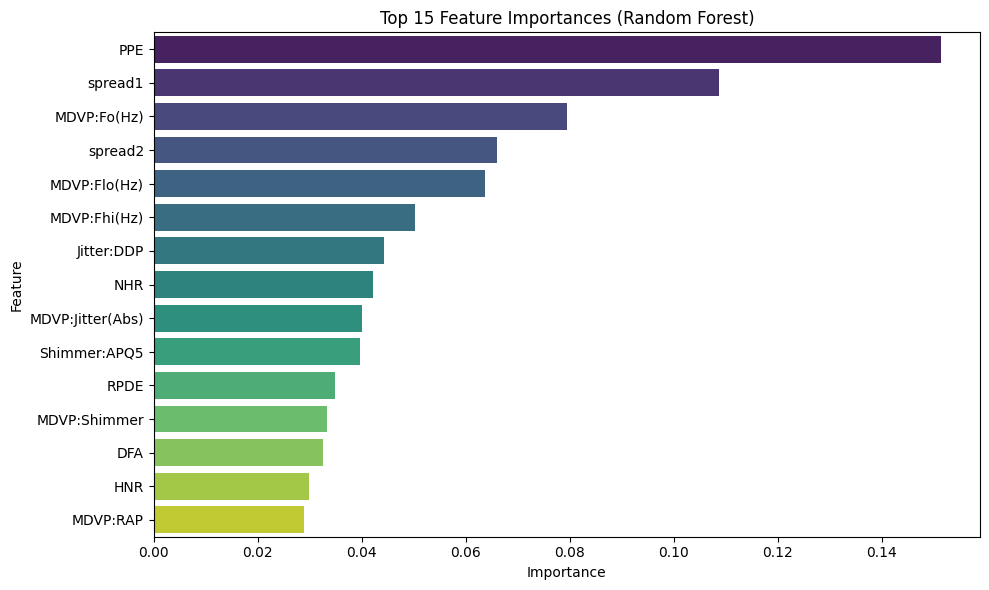

c:\MultipleDiseasePrediction\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:44:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Accuracy: 1.0
Testing Accuracy: 0.9487179487179487

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00       118

    accuracy                           1.00       156
   macro avg       1.00      1.00      1.00       156
weighted avg       1.00      1.00      1.00       156


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.97      0.97      0.97        29

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39



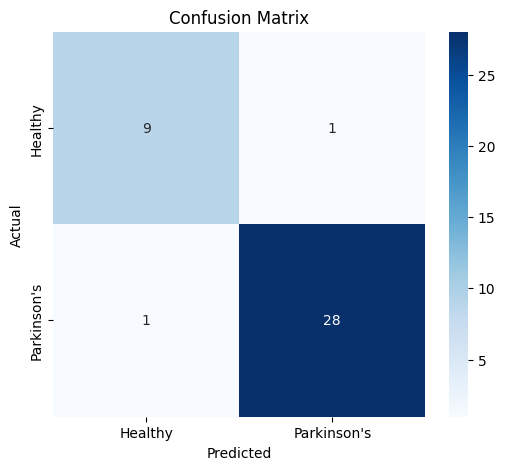

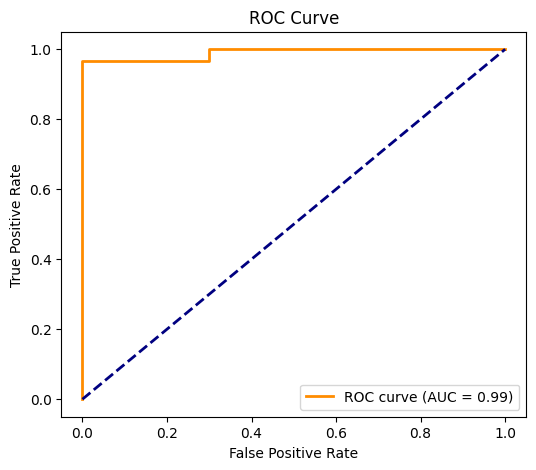

✅ Pipeline saved as parkinsons_xgb_pipeline.pkl


In [33]:
# -------------------------------
# Parkinson's Disease Prediction Pipeline
# Using Top 15 Features + SMOTE + XGBoost
# -------------------------------

# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import cloudpickle

# -------------------------------
# 1. Load data
# -------------------------------
df = pd.read_csv("parkinsons.csv")

# Separate features and target
X = df.drop(columns=['status', 'name'])
y = df['status']

# -------------------------------
# 2. Find top 15 features using RandomForest
# -------------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15).index.tolist()
print("Top 15 features selected:", top_features)

# Plot Top 15 Feature Importances
plt.figure(figsize=(10,6))
sns.barplot(x=importances[top_features].values, y=importances[top_features].index, palette="viridis")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# -------------------------------
# 3. Use only top 15 features for training
# -------------------------------
X_top = X[top_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 4. Build pipeline with scaling + SMOTE + XGBoost
# -------------------------------
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),                        # scale features
    ('smote', SMOTE(random_state=42)),                  # balance classes
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    ))
])

# -------------------------------
# 5. Train pipeline
# -------------------------------
pipeline.fit(X_train, y_train)

# -------------------------------
# 6. Evaluate model
# -------------------------------
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# -------------------------------
# 7. Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Healthy", "Parkinson's"],
            yticklabels=["Healthy", "Parkinson's"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# -------------------------------
# 8. ROC Curve
# -------------------------------
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# 9. Save pipeline
# -------------------------------
with open("parkinsons_xgb_pipeline.pkl", "wb") as f:
    cloudpickle.dump(pipeline, f)

print("✅ Pipeline saved as parkinsons_xgb_pipeline.pkl")
